In [30]:
import networkx as nx
import numpy as np
import pandas as pd

In [31]:
n = 1000 
p = 0.01

G = nx.gnp_random_graph(n, p, directed=True)

print('Number of edges: ', G.number_of_edges())
print('Number of nodes: ', G.number_of_nodes())

Number of edges:  9902
Number of nodes:  1000


In [32]:
def random_strategy(G, num_pivots):
    """
    Select nodes uniformly at random.
    """
    return np.random.choice(list(G.nodes), size=num_pivots, replace=False)


In [33]:
# Function for random selection based on in-degree
def ran_indeg_strategy(G, num_pivots):
    # Get the in-degree of each node
    indegrees = dict(G.in_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node in-degrees
    degree_sum = sum(indegrees.values())
    probabilities = [indegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their in-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [34]:
# Function for random selection based on out-degree
def ran_outdeg_strategy(G, num_pivots):
    # Get the out-degree of each node
    outdegrees = dict(G.out_degree())
    all_nodes = list(G.nodes)
    
    # Create a list of probabilities proportional to node out-degrees
    degree_sum = sum(outdegrees.values())
    probabilities = [outdegrees[node] / degree_sum for node in all_nodes]
    
    # Randomly select pivots with probability proportional to their out-degree
    pivots = np.random.choice(all_nodes, size=num_pivots, replace=False, p=probabilities)
    
    return pivots

In [35]:
def pagerank_pivot_selection(G, num_pivots):
    """
    Select pivots based on PageRank scores.
    
    Parameters:
    - G: NetworkX directed graph (DiGraph)
    - num_pivots: Number of pivots to select
    
    Returns:
    - List of pivot nodes
    """
    # Calculate PageRank scores
    pagerank_scores = nx.pagerank(G)
    
    # Sort nodes by PageRank scores in descending order
    sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
    
    # Select the top nodes as pivots
    pivots = sorted_nodes[:num_pivots]
    return pivots
pivots = pagerank_pivot_selection(G, 3)
pivots

[516, 878, 957]

In [36]:
def euclidean_distance(exact, estimated):
    """
    Compute the normalized Euclidean distance between two centrality dictionaries.
    
    Parameters:
    - exact: dict, exact centrality values
    - estimated: dict, estimated centrality values
    
    Returns:
    - float, the normalized Euclidean distance
    """
    exact_values = np.array([exact[node] for node in exact])
    estimated_values = np.array([estimated[node] for node in exact])  # Ensure consistent order
    
    # Compute the Euclidean distance
    raw_distance = np.linalg.norm(exact_values - estimated_values)
    
    # Normalize by the magnitude of the exact centrality values
    normalization_factor = np.linalg.norm(exact_values)
    if normalization_factor == 0:  # Handle edge case where exact values are all zeros
        return 0.0
    
    return raw_distance / normalization_factor


In [37]:
from itertools import combinations

def compute_inversion_distance(exact_scores, estimated_scores):
    # Rank the nodes based on scores (higher scores get lower ranks)
    exact_ranking = sorted(exact_scores.items(), key=lambda x: x[1], reverse=True)
    estimated_ranking = sorted(estimated_scores.items(), key=lambda x: x[1], reverse=True)

    # Create dictionaries to map nodes to their ranks
    exact_ranks = {node: rank for rank, (node, _) in enumerate(exact_ranking, 1)}
    estimated_ranks = {node: rank for rank, (node, _) in enumerate(estimated_ranking, 1)}

    # Count inversions
    inversion_count = 0
    for u, v in combinations(exact_scores.keys(), 2):  # Compare all pairs of nodes
        exact_order = exact_ranks[u] - exact_ranks[v]  # Positive if u ranks higher than v
        estimated_order = estimated_ranks[u] - estimated_ranks[v]  # Positive if u ranks higher than v
        
        if exact_order * estimated_order < 0:  # Orders are inverted
            inversion_count += 1

    return inversion_count


In [38]:
num_pivots = 1000

exact_closeness = nx.closeness_centrality(G)
exact_betweenness = nx.betweenness_centrality(G)

print(exact_closeness)
print(exact_betweenness)

{0: 0.2849401026811181, 1: 0.31524140107289367, 2: 0.30852378011117976, 3: 0.29365079365079366, 4: 0.2996400719856029, 5: 0.32019230769230766, 6: 0.3008130081300813, 7: 0.32414016872160933, 8: 0.3068181818181818, 9: 0.3017215342796738, 10: 0.3068181818181818, 11: 0.31044126786824117, 12: 0.31573957016434895, 13: 0.31474480151228734, 14: 0.33322214809873246, 15: 0.32091230324445874, 16: 0.2953000295595625, 17: 0.31131193518229977, 18: 0.298744019138756, 19: 0.31365777080062796, 20: 0.2922761849034523, 21: 0.31082762912258866, 22: 0.34177215189873417, 23: 0.3063477460901564, 24: 0.29732142857142857, 25: 0.2897331786542923, 26: 0.28939745075318657, 27: 0.30644171779141105, 28: 0.2970561998215879, 29: 0.3135593220338983, 30: 0.2974099434355463, 31: 0.31474480151228734, 32: 0.2942562592047128, 33: 0.29661520190023755, 34: 0.275282446955084, 35: 0.3348977539389876, 36: 0.31494325346784363, 37: 0.317546090273363, 38: 0.3069124423963134, 39: 0.3019038984587489, 40: 0.2921906990348055, 41: 0.32

In [39]:
all_shortest_paths = dict(nx.all_pairs_all_shortest_paths(G))
print(all_shortest_paths[0][2])

[[0, 526, 842, 22, 2], [0, 642, 730, 189, 2]]


In [40]:
print(all_shortest_paths[0][0][0])

[0]


## Closeness Centrality

1. Select pivots according to the pivot selection strategies
2. Compute distance from pivot to all other nodes in G (d(pivot, node)) for out-closeness centrality.
3. Calculate the sum of all shortest paths
4. Devide the number of pivots by the sum from step 3

In [41]:
pivots = G.nodes
approximated_closeness = {}
for pivot in pivots:
    num_reachable_nodes = 0
    distances = 0
    for node in G.nodes:
        if node in all_shortest_paths and pivot in all_shortest_paths[node]:
            d = len(all_shortest_paths[node][pivot][0]) - 1  # Subtract 1 to get the number of edges
            if d > 0:  # Ensure the distance is valid
                distances += d
                num_reachable_nodes += 1
    approximated_closeness[pivot] = num_reachable_nodes/distances
print(approximated_closeness)

{0: 0.2849401026811181, 1: 0.31524140107289367, 2: 0.30852378011117976, 3: 0.29365079365079366, 4: 0.2996400719856029, 5: 0.32019230769230766, 6: 0.3008130081300813, 7: 0.32414016872160933, 8: 0.3068181818181818, 9: 0.3017215342796738, 10: 0.3068181818181818, 11: 0.31044126786824117, 12: 0.31573957016434895, 13: 0.31474480151228734, 14: 0.33322214809873246, 15: 0.32091230324445874, 16: 0.2953000295595625, 17: 0.31131193518229977, 18: 0.298744019138756, 19: 0.31365777080062796, 20: 0.2922761849034523, 21: 0.31082762912258866, 22: 0.34177215189873417, 23: 0.3063477460901564, 24: 0.29732142857142857, 25: 0.2897331786542923, 26: 0.28939745075318657, 27: 0.30644171779141105, 28: 0.2970561998215879, 29: 0.3135593220338983, 30: 0.2974099434355463, 31: 0.31474480151228734, 32: 0.2942562592047128, 33: 0.29661520190023755, 34: 0.275282446955084, 35: 0.3348977539389876, 36: 0.31494325346784363, 37: 0.317546090273363, 38: 0.3069124423963134, 39: 0.3019038984587489, 40: 0.2921906990348055, 41: 0.32

In [42]:
def run_strategy(G, strategy, num_pivots, all_shortest_paths):
    pivots = strategy(G, num_pivots)
    approximated_closeness = {}
    for node in G.nodes:
        num_reachable_nodes = 0
        distances = 0
        for pivot in pivots:
            if pivot in all_shortest_paths and node in all_shortest_paths[pivot]:
                d = len(all_shortest_paths[pivot][node][0]) - 1  # Subtract 1 to get the number of edges
                if d > 0:  # Ensure the distance is valid
                    distances += d
                    num_reachable_nodes += 1
        approximated_closeness[node] = num_reachable_nodes/distances
    return approximated_closeness

In [43]:
random = run_strategy(G, random_strategy, 1000, all_shortest_paths)
indeg = run_strategy(G, ran_indeg_strategy, 1000, all_shortest_paths)
outdeg= run_strategy(G, ran_outdeg_strategy, 1000, all_shortest_paths)
pr = run_strategy(G, pagerank_pivot_selection, 10, all_shortest_paths)

pr

{0: 0.2777777777777778,
 1: 0.38461538461538464,
 2: 0.3448275862068966,
 3: 0.3225806451612903,
 4: 0.3125,
 5: 0.30303030303030304,
 6: 0.30303030303030304,
 7: 0.30303030303030304,
 8: 0.3333333333333333,
 9: 0.3448275862068966,
 10: 0.3125,
 11: 0.2857142857142857,
 12: 0.3125,
 13: 0.30303030303030304,
 14: 0.3125,
 15: 0.30303030303030304,
 16: 0.2777777777777778,
 17: 0.30303030303030304,
 18: 0.3125,
 19: 0.29411764705882354,
 20: 0.29411764705882354,
 21: 0.30303030303030304,
 22: 0.34615384615384615,
 23: 0.3448275862068966,
 24: 0.2857142857142857,
 25: 0.2857142857142857,
 26: 0.29411764705882354,
 27: 0.2857142857142857,
 28: 0.29411764705882354,
 29: 0.35714285714285715,
 30: 0.3225806451612903,
 31: 0.3333333333333333,
 32: 0.29411764705882354,
 33: 0.2857142857142857,
 34: 0.2631578947368421,
 35: 0.37037037037037035,
 36: 0.3333333333333333,
 37: 0.3225806451612903,
 38: 0.3225806451612903,
 39: 0.2857142857142857,
 40: 0.2857142857142857,
 41: 0.3333333333333333,
 42:

In [44]:
strategies = [random_strategy, ran_indeg_strategy, 
              ran_outdeg_strategy, pagerank_pivot_selection]

num_pivots_list = [int(len(G.nodes) / 20 * i) for i in range(1, 21)]
print(num_pivots_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [48]:
from tqdm import tqdm 

def run_experiment(G, strategies, num_pivots_list, all_shortest_paths, exact_closeness, runs=20):
    results = {}

    for strategy in strategies:
            results[strategy.__name__] = {}
            for num_pivots in num_pivots_list:
                appr_closeness = run_strategy(G, strategy, num_pivots, all_shortest_paths)
                
                eucl_dist = euclidean_distance(exact_closeness, appr_closeness)
                inversion = compute_inversion_distance(exact_closeness, appr_closeness)
                results[strategy.__name__][num_pivots] = {
                    'euclidean_distance': eucl_dist,
                    'inversion_number': inversion
                }
    return results


results = run_experiment(G, strategies, num_pivots_list, all_shortest_paths, exact_closeness)

In [49]:
print(results)

{'random_strategy': {50: {'euclidean_distance': 0.026652605066706105, 'inversion_number': 81161}, 100: {'euclidean_distance': 0.017958769531209475, 'inversion_number': 56990}, 150: {'euclidean_distance': 0.015594328179370419, 'inversion_number': 51396}, 200: {'euclidean_distance': 0.011138676531603076, 'inversion_number': 36126}, 250: {'euclidean_distance': 0.01119972886887436, 'inversion_number': 34532}, 300: {'euclidean_distance': 0.009345582495758026, 'inversion_number': 30283}, 350: {'euclidean_distance': 0.009311608833845107, 'inversion_number': 28188}, 400: {'euclidean_distance': 0.0074254386799373455, 'inversion_number': 24537}, 450: {'euclidean_distance': 0.007088489546788591, 'inversion_number': 23880}, 500: {'euclidean_distance': 0.005890560156055603, 'inversion_number': 19433}, 550: {'euclidean_distance': 0.005890589827388721, 'inversion_number': 18874}, 600: {'euclidean_distance': 0.0054602150340858245, 'inversion_number': 18270}, 650: {'euclidean_distance': 0.0046221696538

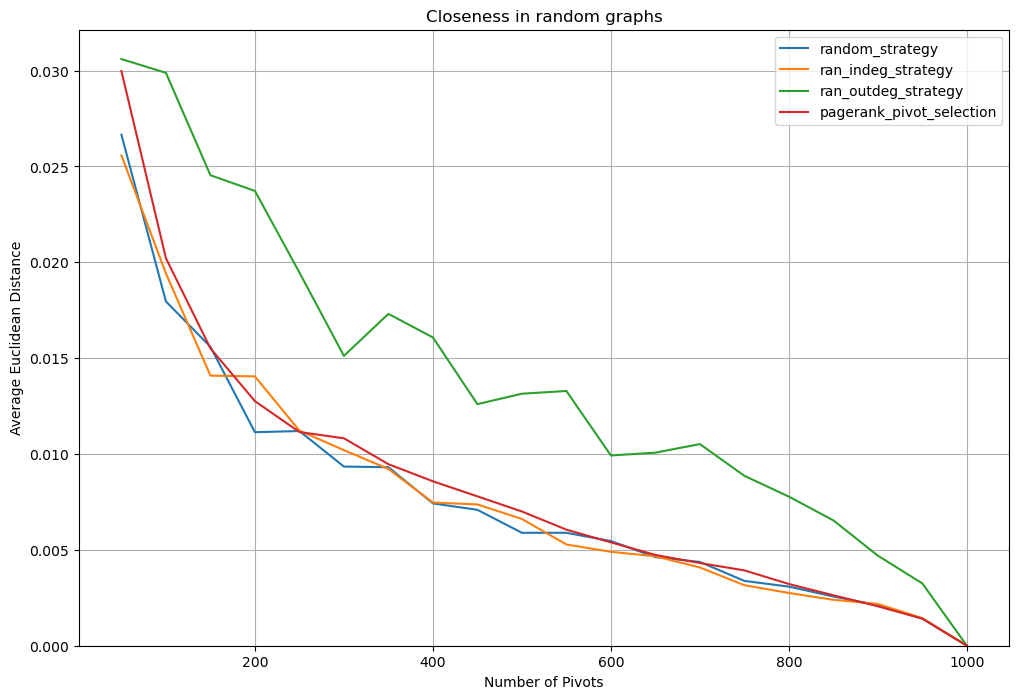

In [50]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["euclidean_distance"] for metrics in data.values()]  # Extract Euclidean distance
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.grid(True)
plt.show()

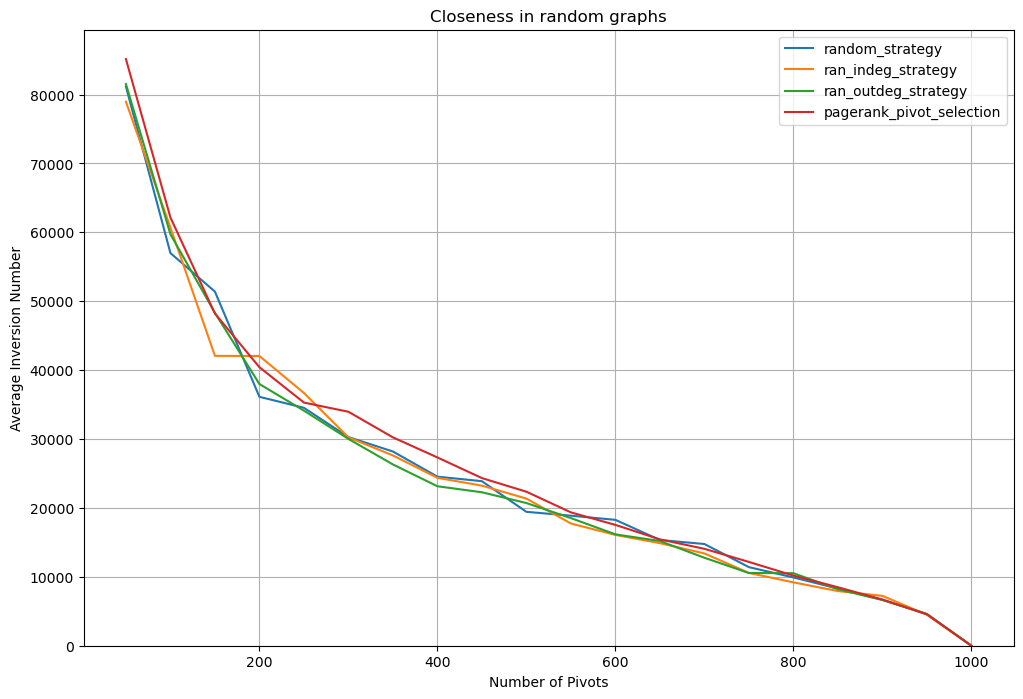

In [51]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["inversion_number"] for metrics in data.values()]  # Extract Inversion number
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Inversion Number")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.grid(True)
plt.show()


## Betweenness

In [52]:
print(exact_betweenness)
print(len(all_shortest_paths))

{0: 0.0008141089338823008, 1: 0.002067613428724526, 2: 0.0007742537641981212, 3: 0.002310714813487518, 4: 0.0015146265559924502, 5: 0.003656759051474103, 6: 0.0014715731607989981, 7: 0.003077174003275998, 8: 0.002232518594515929, 9: 0.0014378833427591258, 10: 0.0019126177191013535, 11: 0.003230963228830794, 12: 0.0022390655388714563, 13: 0.0033968221710562064, 14: 0.0031574904510203784, 15: 0.001086432678942758, 16: 0.001893888449400924, 17: 0.0027112791045337177, 18: 0.0017867157391710865, 19: 0.0015508684832638523, 20: 0.0013190944386315285, 21: 0.00246360205585986, 22: 0.0062324290124231825, 23: 0.002288068789846159, 24: 0.0020955795972236817, 25: 0.0017410213001679028, 26: 0.0009288668202463889, 27: 0.002620781864052491, 28: 0.00237192699979005, 29: 0.002741895021542357, 30: 0.002133520272496741, 31: 0.0026989262916781147, 32: 0.0013960148432509592, 33: 0.00161182277112948, 34: 0.0007696859348812975, 35: 0.004124975165484678, 36: 0.0034675658429967103, 37: 0.0029855811894482632, 38

In [53]:
first_two = dict(list(all_shortest_paths.items())[:2])
print(first_two)

{0: {0: [[0]], 1: [[0, 74, 1]], 2: [[0, 526, 842, 22, 2], [0, 642, 730, 189, 2]], 3: [[0, 464, 156, 3], [0, 526, 434, 3]], 4: [[0, 464, 335, 4]], 5: [[0, 30, 144, 985, 5], [0, 416, 771, 89, 5], [0, 464, 308, 89, 5], [0, 416, 922, 696, 5], [0, 642, 974, 696, 5], [0, 867, 963, 696, 5], [0, 464, 543, 684, 5], [0, 867, 963, 752, 5]], 6: [[0, 30, 851, 6]], 7: [[0, 416, 14, 367, 7], [0, 642, 542, 367, 7], [0, 642, 544, 367, 7], [0, 416, 412, 425, 7], [0, 464, 308, 886, 7], [0, 464, 335, 484, 7], [0, 526, 320, 885, 7], [0, 526, 842, 914, 7], [0, 642, 974, 226, 7], [0, 867, 459, 226, 7]], 8: [[0, 642, 354, 8], [0, 642, 995, 8]], 9: [[0, 464, 156, 9]], 10: [[0, 416, 771, 433, 10], [0, 464, 156, 163, 10], [0, 642, 542, 163, 10], [0, 642, 674, 163, 10]], 11: [[0, 30, 160, 11]], 12: [[0, 30, 851, 12], [0, 416, 412, 12]], 13: [[0, 464, 67, 13]], 14: [[0, 416, 14]], 15: [[0, 30, 851, 15], [0, 464, 220, 15]], 16: [[0, 74, 119, 150, 16], [0, 464, 775, 150, 16], [0, 867, 963, 150, 16], [0, 526, 783, 62

In [54]:
print(len(all_shortest_paths[0][2]))

2


In [55]:
pivots = G.nodes
num_nodes = len(G.nodes)
num_all_shortest_paths = len(all_shortest_paths)
approximated_betweenness = {node: 0 for node in G.nodes}
for pivot in pivots:
    for node in G.nodes:
        if node == pivot:
            continue
        num_paths = len(all_shortest_paths[pivot][node])
        for shortest_path in all_shortest_paths[pivot][node]:
            for i in range(1, len(shortest_path)-1):
                contributor = shortest_path[i]
                approximated_betweenness[contributor] += (1 / ((num_nodes-1)*(num_nodes-2)*num_paths))
print(approximated_betweenness)

{0: 0.000814108933882306, 1: 0.0020676134287244065, 2: 0.0007742537641981302, 3: 0.0023107148134873566, 4: 0.0015146265559923984, 5: 0.0036567590514737383, 6: 0.0014715731607989556, 7: 0.0030771740032757297, 8: 0.002232518594515784, 9: 0.0014378833427590846, 10: 0.0019126177191012444, 11: 0.0032309632288304987, 12: 0.0022390655388713275, 13: 0.0033968221710558456, 14: 0.003157490451020086, 15: 0.0010864326789427536, 16: 0.001893888449400815, 17: 0.0027112791045334995, 18: 0.001786715739171006, 19: 0.0015508684832638009, 20: 0.0013190944386315066, 21: 0.0024636020558596655, 22: 0.00623242901242295, 23: 0.002288068789846016, 24: 0.00209557959722356, 25: 0.0017410213001678356, 26: 0.0009288668202463991, 27: 0.002620781864052251, 28: 0.0023719269997898706, 29: 0.002741895021542126, 30: 0.0021335202724966037, 31: 0.0026989262916779022, 32: 0.0013960148432509063, 33: 0.0016118227711294083, 34: 0.0007696859348813061, 35: 0.004124975165484324, 36: 0.003467565842996353, 37: 0.002985581189448028

In [56]:
def run_strategy_betweenness(G, strategy, num_pivots, all_shortest_paths):
    pivots = strategy(G, num_pivots)
    num_nodes = len(G.nodes)
    approximated_betweenness = {node: 0 for node in G.nodes}
    scaling_factor = num_nodes / num_pivots

    for pivot in pivots:
        for node in G.nodes:
            if node == pivot:
                continue
            num_paths = len(all_shortest_paths[pivot][node])
            for shortest_path in all_shortest_paths[pivot][node]:
                for i in range(1, len(shortest_path)-1):
                    contributor = shortest_path[i]
                    approximated_betweenness[contributor] += scaling_factor * (1 / ((num_nodes-1)*(num_nodes-2)*num_paths))
    return approximated_betweenness

In [57]:
test = run_strategy_betweenness(G, ran_indeg_strategy, 900, all_shortest_paths)
print(test)
dist = euclidean_distance(exact_betweenness, test)
dist

{0: 0.0008364400593932571, 1: 0.0021288185387760158, 2: 0.0006303458275906165, 3: 0.0022858231024807715, 4: 0.0015558148503647853, 5: 0.0035189711681177477, 6: 0.0015568999400001283, 7: 0.002929462988234513, 8: 0.0022587021683723838, 9: 0.001495730023648362, 10: 0.0020116169560496014, 11: 0.0033261705345844586, 12: 0.002282964842759533, 13: 0.00349498976056274, 14: 0.0031454535145562564, 15: 0.0010374533939088452, 16: 0.0019776385605672054, 17: 0.002720127051390998, 18: 0.0018401385559115285, 19: 0.0016093561144784692, 20: 0.0011902765766240923, 21: 0.0024678862537754723, 22: 0.0065431351993608545, 23: 0.0021689750836969292, 24: 0.0022052143513608324, 25: 0.0018448615302167522, 26: 0.0009829261210976307, 27: 0.00272289262535425, 28: 0.0024854097026097244, 29: 0.0027107475633813805, 30: 0.00225807641026628, 31: 0.0025581295083451183, 32: 0.0015180911952245792, 33: 0.001353103227878899, 34: 0.0008010568709375713, 35: 0.004130136866709995, 36: 0.0035699384167176174, 37: 0.0030475466832351

0.050350865716516896

In [58]:
strategies = [random_strategy, ran_indeg_strategy, 
              ran_outdeg_strategy, pagerank_pivot_selection]

num_pivots_list = [int(len(G.nodes) / 20 * i) for i in range(1, 21)]
print(num_pivots_list)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]


In [59]:
def run_experiment_betweenness(G, strategies, num_pivots_list, all_shortest_paths, exact_betweenness):
    results = {}
    for strategy in strategies:
        print(strategy.__name__)
        results[strategy.__name__] = {}
        for num_pivots in num_pivots_list:
            approximated_betweenness = run_strategy_betweenness(G, strategy, num_pivots, all_shortest_paths)
            
            eucl_dist = euclidean_distance(exact_betweenness, approximated_betweenness)
            inversion = compute_inversion_distance(exact_betweenness, approximated_betweenness)
            results[strategy.__name__][num_pivots] = {
                'euclidean_distance': eucl_dist,
                'inversion_number': inversion
            }
    return results


results_betweenness = run_experiment_betweenness(G, strategies, num_pivots_list, all_shortest_paths, exact_betweenness)

random_strategy
ran_indeg_strategy
ran_outdeg_strategy
pagerank_pivot_selection


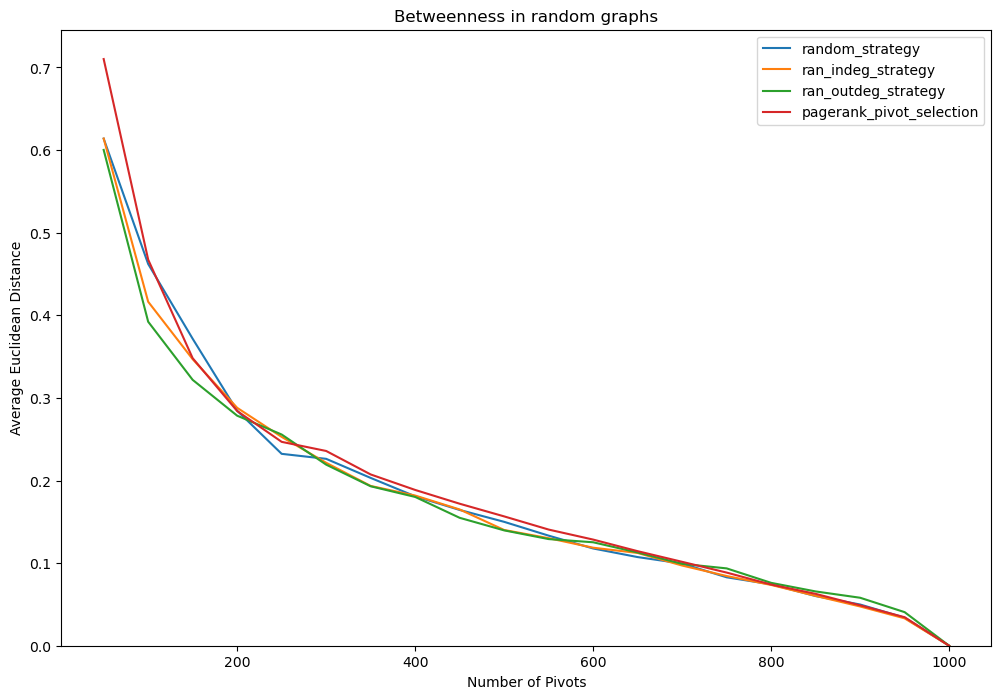

In [60]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results_betweenness.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["euclidean_distance"] for metrics in data.values()]  # Extract Euclidean distance
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Euclidean Distance")
plt.title("Betweenness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.show()

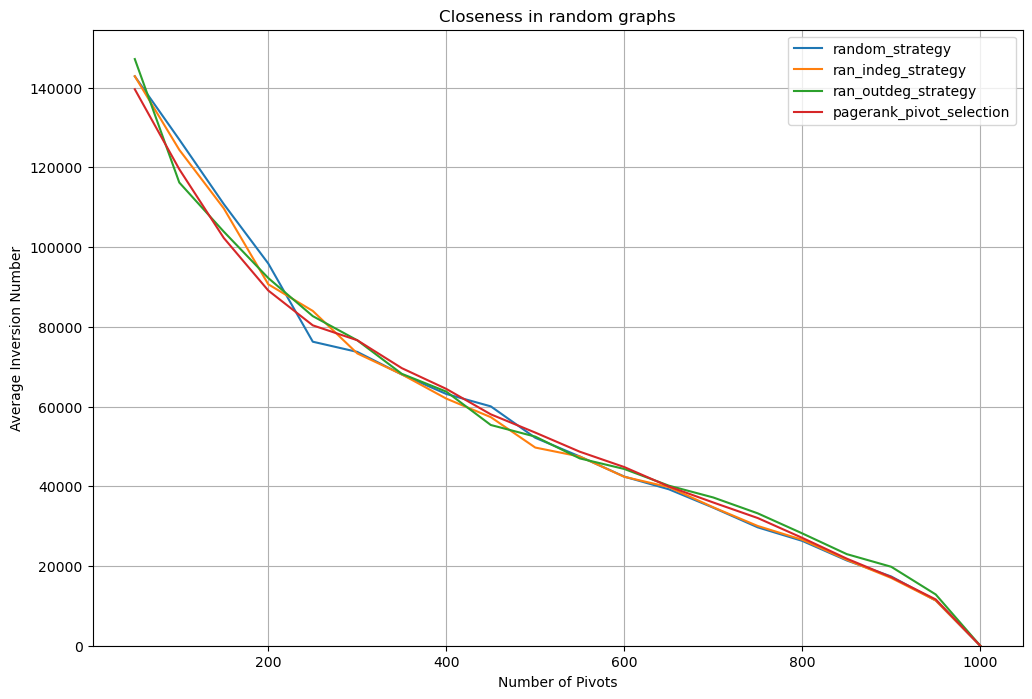

In [61]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for strategy, data in results_betweenness.items():
    x = list(data.keys())  # Number of pivots
    y = [metrics["inversion_number"] for metrics in data.values()]  # Extract Inversion number
    plt.plot(x, y, label=strategy)

plt.xlabel("Number of Pivots")
plt.ylabel("Average Inversion Number")
plt.title("Closeness in random graphs")
plt.legend()
plt.ylim(0, None)
plt.grid(True)
plt.show()